In [3]:
from utility_dnn import *
import utility_common as common

from IPython.display import clear_output
## add plotting option and load plotting parameter table
%matplotlib inline
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("savefig",dpi=300)

selection,nbjet = "ee",">1"

# 0. Load Data 

In [4]:
tr = TrainingDataLoader(selection,nbjet)
tr.loadData()
trainset = MyDataset(tr.df_train.as_matrix(),tr.nvar)
trainloader = DataLoader(trainset, batch_size=1000,shuffle=True, num_workers=4)

# 1. Define DNN and Train DNN

In [10]:
net = Net(tr.nvar,64,32,16,2)
#net = torch.load(common.getBaseDirectory()+"data/networks/{}{}.pt".format(selection,tr.bname))

In [17]:
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
for epoch in range(500):
    running_loss = 0.0
    for i, onebatch in enumerate(trainloader,0):
        # get the inputs
        inputs = Variable(onebatch["feature"])#.cuda()
        labels = Variable(onebatch["label"])#.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data[0]    
    clear_output(wait=True)
    print('[%d] loss: %.5f' %(epoch + 1, running_loss))

print('Finished Training')
torch.save(net,common.getBaseDirectory()+"data/networks/{}{}.pt".format(selection,tr.bname))

[500] loss: 1.29084
Finished Training


# 3. Test Accuracy

In [18]:
plotter = DFPlotter(selection,nbjet)
dfList = plotter.getDataFrameList()
grader = DNNGrader(selection,nbjet)

In [19]:
dfList = grader.gradeDFList(dfList)

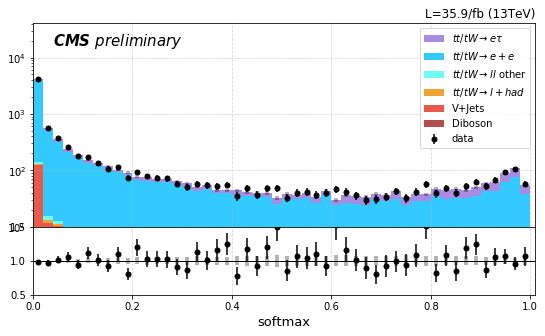

In [20]:
sk = ASingleKinematicPlot("softmax",0,1.01,0.02,dfList)
sk.settingPlot("softmax",plotter.labelList, plotter.colorList,logscale= True,figuresize = (9,5))
sk.makePlot(common.getBaseDirectory()+'plots/score/{}{}'.format(selection,grader.bname))

In [21]:
sg = dfList[5]
bg = pd.concat(dfList[1:5],ignore_index=True)

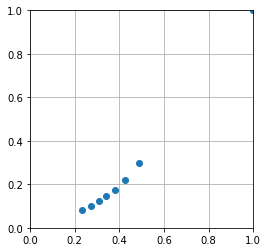

In [25]:
effmcsg,effmcbg = np.ones(1),np.ones(1)
for thrd in np.arange(0.00,0.8,0.1):
    effmcsg = np.append(effmcsg, np.sum(sg.query('softmax>{}'.format(thrd)).eventWeight)/np.sum(sg.eventWeight) )
    effmcbg = np.append(effmcbg, np.sum(bg.query('softmax>{}'.format(thrd)).eventWeight)/np.sum(bg.eventWeight) )

plt.figure(figsize=(4,4))   
plt.scatter(effmcsg,effmcbg)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)

In [37]:
data = dfList[-1]
corr = data.corr()
corr = corr['softmax']
for v in tr.var_list:
    print('{:20} : {:5.3}'.format(v,corr[v]))

dijet_eta            : 0.0339
dijet_mass           : -0.00824
dijet_phi            : -0.00167
dijet_pt             : -0.00518
dijet_pt_over_m      : 0.0144
dilepton_eta         : 0.0468
dilepton_mass        : -0.058
dilepton_phi         : -0.00348
dilepton_pt          : -0.117
dilepton_pt_over_m   : -0.0559
jet1_energy          : -0.0231
jet1_eta             : 0.00459
jet1_phi             : 0.0115
jet1_pt              : 0.00366
jet1_tag             : 0.000242
jet2_energy          : 0.00393
jet2_eta             : 0.0392
jet2_phi             : -0.00918
jet2_pt              : -0.00188
jet2_tag             : -0.0173
jet_delta_eta        : -0.0281
jet_delta_phi        : -0.00179
jet_delta_r          : -0.0192
lepton1_energy       : -0.0544
lepton1_eta          : 0.0412
lepton1_reliso       : 0.0312
lepton1_phi          : -0.021
lepton1_pt           : -0.0822
lepton2_energy       : -0.0935
lepton2_eta          : 0.0414
lepton2_reliso       : 0.0184
lepton2_phi          : 0.0223
lepton2_pt   

In [20]:
filterdf_list = []
slt = "softmax>=0.05"
for i in range(len(df_list)):
    filterdf_list.append(df_list[i].query(slt))

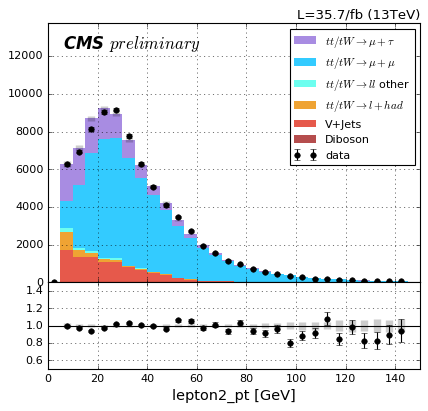

In [28]:
plotter = SelectionPlotter("lepton2_pt",0,150,5,df_list)
plotter.settingPlot("lepton2_pt [GeV]",label_list,color_list,                    
                    logscale   = False,
                    isstacked  = True,
                    figuresize = (6,5.4))
plotter.makePlot()

## Plot All Variables with the Score Cut

In [21]:
pp = pd.read_csv("plotter/plotparameters.csv")
for index, row in pp.iterrows():
    v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
    plotter = SelectionPlotter(v,a,b,step,df_list)
    plotter.settingPlot(xl,label_list,color_list,                    
                       logscale   = False,
                       isstacked  = True,
                       figuresize = (6,5.4))
    plotter.makePlot('../plot/{}/combined_{}/'.format(selection,slt))
    
    # print out process
    print("making plots: {0}/{1}".format(index,len(pp)))
    clear_output(wait=True)
    plt.close()
print('finish all making plots')

finish all making plots
